# Gaussian mixture model


This is the code for a GMM with three components and some niiiiice visualization for some tutorial I once gave but cannot remember where.

In [1]:
library(mvtnorm)
library(MASS)
options(repr.plot.width=6, repr.plot.height=5)

Create some data

In [2]:
.create.data <- function(n)
{
  l <- list()
  l[[1]] <- list(component=1,
    mixing.weight=0.5,
                 means=c(0,0),
                 cov=matrix(c(1,0,0,1), ncol=2, byrow=T))
  l[[2]] <- list(mixing.weight=0.3,
                 component=2,
                 means=c(5,5),
                 cov=matrix(c(1, 0.5, 0.5, 1), ncol=2, byrow=T))
  l[[3]] <- list(mixing.weight=0.2,
                 component=3,
                 means=c(10,10),
                 cov=matrix(c(1,0.75,0.75,1), ncol=2, byrow=T))

  do.call("rbind",sapply(l, function(e) {
    dat <- mvtnorm::rmvnorm(e$mixing.weight * n, e$means, e$cov)
    cbind(component=e$component,
          x1=dat[,1],
          x2=dat[,2])
  }))
}


In [3]:
.create.data(10)

component,x1,x2
1,-0.3352487,0.95033485
1,1.1274445,0.09390217
1,-0.4505194,0.85063985
1,-0.3417464,-0.84372331
1,-0.3414623,0.64019258
2,4.4075011,4.27303647
2,4.5319822,5.87366353
2,3.4955392,4.24523111
3,10.4209740,9.92189156
3,10.6125860,10.45986811


Function to "randomly" initialize the three components.

In [4]:
.init <- function()
{
  l <- list()
  l[[1]] <- list(mixing.weight=0.1,
                 means=c(-2, -2),
                 cov=matrix(c(1,0,0,1), ncol=2, byrow=T))
  l[[2]] <- list(mixing.weight=0.1,
                 means=c(10, 0),
                 cov=matrix(c(1,0,0,1), ncol=2, byrow=T))
  l[[3]] <- list(mixing.weight=0.8,
                 means=c(0, 10),
                 cov=matrix(c(1,0,0,1), ncol=2, byrow=T))

  l
}

In [5]:
.init()

1,0
0,1
1,0
0,1
1,0
0,1


Function to compute the update of the covariance matrix, We will only need that for the M-step.

In [6]:
.cov <- function(n, r, dat, m, N.k)
{
  (t(r * (dat[,2:3] -m))  %*%  (( dat[,2:3]-m))) / N.k
}

We use this for creating a scatter plot later

In [7]:
# Do a scatter plot
.scatter <- function(dat, clusters)
{
  plot(dat[,2], dat[,3], xlab="", ylab="", main="", 
       col=c("blue", "red", "orange", "black")[clusters], pch=(1:4)[clusters])  
  col    <- c("blue", "red", "orange")
  pch    <- 1:3
  legend <- paste("Cluster", 1:3)
  if (clusters[1] == 4) {
    col <- "black"
    pch <- 4
    legend = "No clusters"
  }
  legend("topleft", col=col, pch=pch, legend=legend, cex = 1,  box.lty=0)
}

This is a function to compute a 2-dimensional kernel density estimate. We use it for plotting contours later.

In [8]:
.contour <- function(means, cov, l)
{
  X <- mvtnorm::rmvnorm(1000, means, cov)
  z <- MASS::kde2d(X[,1], X[,2], n=50)
  contour(z, drawlabels=FALSE, add=TRUE, lty=l, lwd=1.5)
}

Here we do the actual clustering.

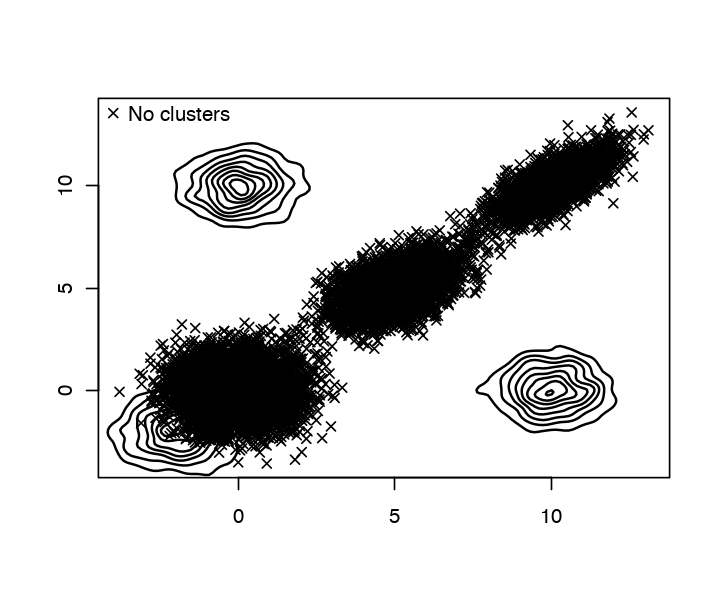

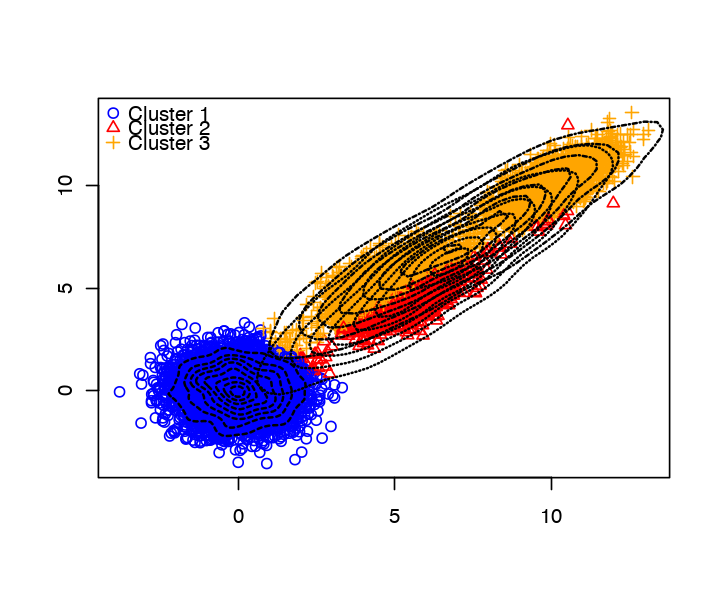

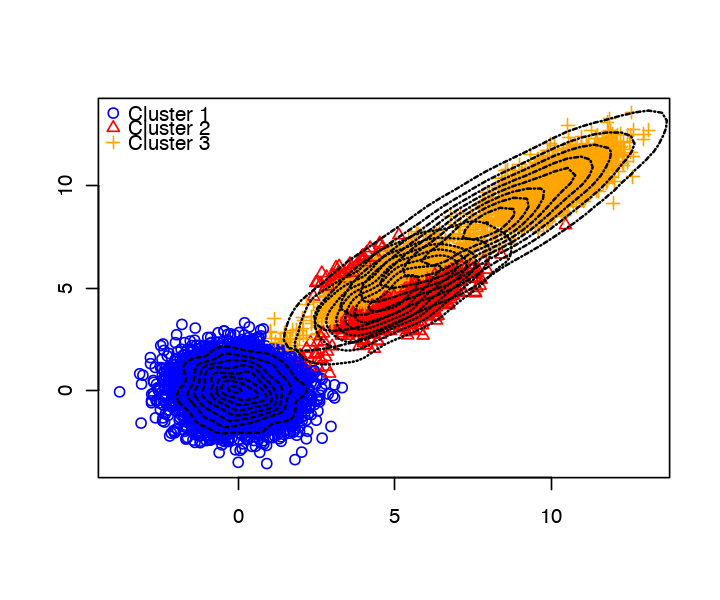

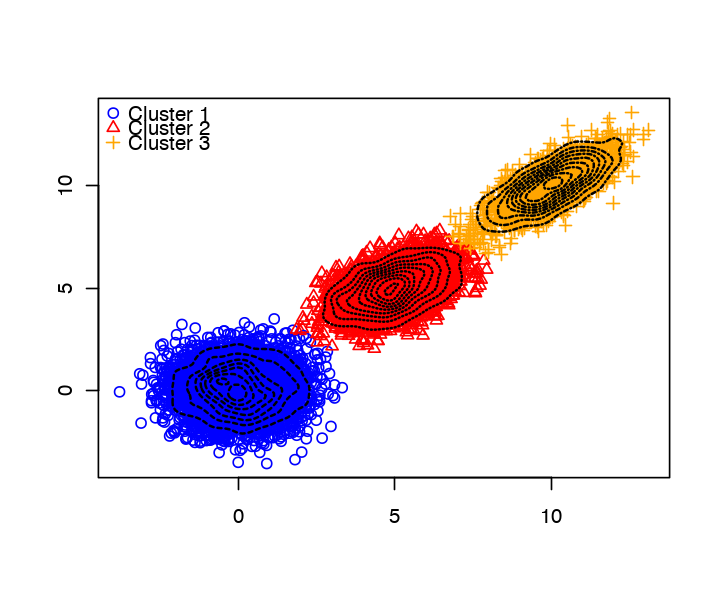

In [9]:
n   <- 10000
# create data with n samples
dat <- .create.data(n)

l <- .init()
.scatter(dat, 4)
invisible(lapply(1:3, function(e) .contour(l[[e]]$means, l[[e]]$cov, 1)))

for (i in seq(30))
{
    ### E step
    re <- sapply(l, function(r) {
      r$mixing.weight *  mvtnorm::dmvnorm(dat[,2:3], r$means, r$cov)
    })
    r <- apply(re, 1, sum)
    rs <- re / r
    N.k <- apply(rs, 2, sum)

    ### M step
    m <- lapply(1:3, function(e) {
      apply(rs[,e] * dat[,2:3], 2, sum) / N.k[e]
    })
    c <- lapply(1:3, function(e) {
      .cov(n, rs[,e], dat, m[[e]], N.k[e])
    })
    mi <- N.k / n
    l <- lapply(1:3, function(e) {
      list(mixing.weight = mi[e], means=m[[e]], cov=c[[e]])
    })
    if (i %% 10 == 0) {
      Sys.sleep(1.5)
      .scatter(dat, apply(rs, 1, which.max))
      invisible(lapply(1:3, function(e) .contour(l[[e]]$means, l[[e]]$cov, e + 1)))
    }
}               